<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_NN_LDS_to_OccupancyMap_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: NN prediction of Occupancy Map from LDS (v2)
The first version had a number of problems:
* Very slow to execute (takes about 2 mins to train on TPU for just 5 epochs across 1000 samples each)
* Performs very poorly

Here I'll experiment with a couple of variations of NN architecture to improve the speed of execution and the speed of convergence. My suspicion is that I'll get good results with a combination of:
* ResNet - better convergence due to being able to learn the Identity function easily
* MobileNet "Depthwise Separable Convolution" - faster execution due to about a 1/10th the number of parameters

In [41]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
!cd repo && git checkout e278a71
#!cd repo && git pull

import sys
sys.path.append('repo')

import lds
import lds_train_data
from importlib import reload
reload(lds)
reload(lds_train_data)

HEAD is now at 2d69f33 Bug fix in padding used by rotated_crop
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 1), reused 4 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 297.31 KiB | 7.62 MiB/s, done.
From https://github.com/malcolmlett/robovac
   2d69f33..e278a71  main       -> origin/main
Updating 2d69f33..e278a71
Fast-forward
 data/experimental-lds-training-data1.npz | Bin 0 -> 313853 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 data/experimental-lds-training-data1.npz


<module 'lds_train_data' from '/content/repo/lds_train_data.py'>

In [2]:
!pip install -Uqq ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.8 MB/s eta 0:00:00


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Add
from PIL import Image
import io
import cv2
import requests
import math
import ipdb
from timeit import default_timer as timer

In [4]:
floorplan = Image.open('repo/data/experimental-floorplan1.png')
floorplan = np.array(floorplan, dtype=bool)
print(f"floorplan: shape={floorplan.shape}, dtype={floorplan.dtype}")

floorplan: shape=(84, 94), dtype=bool


## Training data generation

In [ ]:
# If generated data is available then load that to save time:
loaded = np.load('repo/data/experimental-lds-training-data1.npz')
X = loaded['X']
Y = loaded['Y']
print(f"X: {len(X)} x {X[0].shape}")
print(f"Y: {len(Y)} x {Y[0].shape}")

# show first 5
plt.figure(figsize=(4, 10))
for i in range(0,5):
  plt.subplot(5,2,i*2+1)
  plt.imshow(X[i], cmap='gray')
  plt.axis('off')

  plt.subplot(5,2,i*2+2)
  plt.imshow(Y[i], cmap='gray')
  plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'repo/data/experimental-lds-training-data1.npz'

100%|██████████| 1000/1000 [00:50<00:00, 19.86it/s]


X: 1000 x (105, 105)
Y: 1000 x (105, 105)


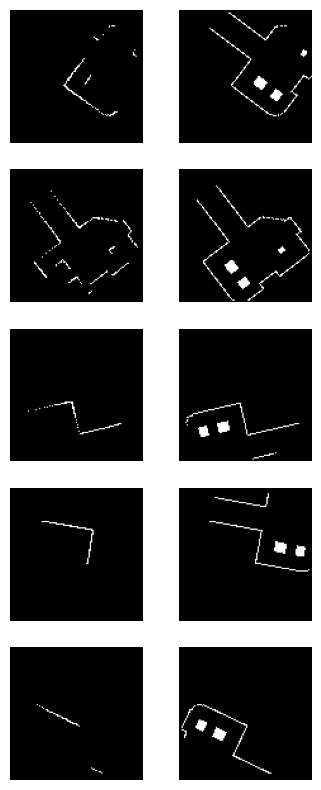

In [5]:
reload(lds_train_data)
np.random.seed(0)
X, Y = lds_train_data.generate_training_data(floorplan, 1000, pixel_size=6.8, max_distance=350)
print(f"X: {len(X)} x {X[0].shape}")
print(f"Y: {len(Y)} x {Y[0].shape}")

# show first 5
plt.figure(figsize=(4, 10))
for i in range(0,5):
  plt.subplot(5,2,i*2+1)
  plt.imshow(X[i], cmap='gray')
  plt.axis('off')

  plt.subplot(5,2,i*2+2)
  plt.imshow(Y[i], cmap='gray')
  plt.axis('off')
plt.show()

In [6]:
# Save for later re-loading
# (needs to be manually downloaded and saved to repo)
np.savez_compressed('experimental-lds-training-data1.npz', X=X, Y=Y)

In [32]:
# Make available for training
# (and optionally pre-process with padding to make the image width/height divisible by 16)
pre_process = False

def pad_images(x, y):
  # image comes in as (height, width) but pad_to_bounding_box needs (height, width, channels)
  x = x[:,:,np.newaxis]
  y = y[:,:,np.newaxis]
  target_h = x.shape[0] + pad_h
  target_w = x.shape[1] + pad_w
  x_padded = tf.image.pad_to_bounding_box(x, offset_height=pad_h//2, offset_width=pad_w//2, target_height=target_h, target_width=target_w)
  y_padded = tf.image.pad_to_bounding_box(y, offset_height=pad_h//2, offset_width=pad_w//2, target_height=target_h, target_width=target_w)
  x_padded = x_padded[:,:,0]
  y_padded = y_padded[:,:,0]
  return (x_padded, y_padded)

dataset = tf.data.Dataset.from_tensor_slices((X, Y))
if pre_process:
  pad_h = 16 - X[0].shape[0] % 16
  pad_w = 16 - X[0].shape[1] % 16
  print(f"Input size: {X[0].shape}")
  if pad_h > 0 or pad_w > 0:
    dataset = dataset.map(pad_images)
    print(f"Added pre-processed padding: w={pad_w}, h={pad_h}")

In [8]:
# Let's confirm that the Dataset is GPU compatible
# (After lots of experimentation, it seems that Datasets do pre-processing on the CPU and then transfer batches to the GPU.
# I don't know for certain that it's doing that correctly here, but I don't get any difference if I try to explicitly wrap things in tensors before
# adding to the dataset)
print(f"Devices available: {tf.config.list_physical_devices()}")
for element in dataset.take(1):
  print(f"element[0]:  {type(element[0])} of {element[0].shape} on {element[0].device}")
  print(f"element[1]:  {type(element[1])} of {element[1].shape} on {element[1].device}")
  print(f"element[0][0]:  {type(element[0][0])} of {element[0][0].shape} on {element[0][0].device}")  # operations occur on GPU, yay!

Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
element[0]:  <class 'tensorflow.python.framework.ops.EagerTensor'> of (105, 105) on /job:localhost/replica:0/task:0/device:CPU:0
element[1]:  <class 'tensorflow.python.framework.ops.EagerTensor'> of (105, 105) on /job:localhost/replica:0/task:0/device:CPU:0
element[0][0]:  <class 'tensorflow.python.framework.ops.EagerTensor'> of (105,) on /job:localhost/replica:0/task:0/device:GPU:0


# Simple UNet
For baselining performance, the same simple UNet from before, based very heavily on MIT's Deep Learning Specialization, C4W3A2.

* Total params: 8,639,202 (32.96 MB)
* Trainable params: 8,639,202 (32.96 MB)
* Training speed: 130ms/step (batch size 32, padding done as layer)


In [9]:
def unet_conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block.

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=(3,3),   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=(3,3),   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv

    skip_connection = conv
    return next_layer, skip_connection

In [10]:
def unet_upsampling_block(expansive_input, contractive_input, n_filters=32, merge_mode='concat'):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
        merge_mode -- one of: 'concat' or 'add'
    Returns:
        conv -- Tensor output
    """

    up = Conv2DTranspose(
                 filters=n_filters,    # number of filters
                 kernel_size=(3,3),    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    if merge_mode == 'concat':
      merge = Concatenate(axis=3)([up, contractive_input])
    elif merge_mode == 'add':
      merge = Add()([up, contractive_input])
    else:
      raise ValueError(f"Unknown merge mode: {merge_mode}")

    conv = Conv2D(n_filters,            # Number of filters
                 kernel_size=(3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,          # Number of filters
                 kernel_size=(3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)

    return conv

In [11]:
def unet_model(input_size, n_filters, n_classes, merge_mode='concat'):
    """
    Unet model.

    Has 4 2x2 downsampling blocks matched up with 4 2x2 upsampling blocks.
    The input dimensions must be multiples of 2**4 = 16 or off-by-one errors
    will occur.

    Arguments:
        input_size (x, y, channels) -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
        merge_mode -- one of: 'concat' or 'add'
    Returns:
        model -- tf.keras.Model
    """
    # Prepare input
    # (Pad up to the nearest multiple of 16 if needed)
    inputs = Input(input_size)
    pad_h = 16 - input_size[0] % 16
    pad_w = 16 - input_size[1] % 16
    print(f"Input size: {input_size}")
    if pad_h > 0 or pad_w > 0:
      print(f"Added padding layer: w={pad_w}, h={pad_h}")
      padded_inputs = ZeroPadding2D(padding=((pad_h//2, pad_h-pad_h//2), (pad_w//2, pad_w-pad_w//2)))(inputs)
    else:
      padded_inputs = inputs

    print(f"Skip-connection merge mode: {merge_mode}")

    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet model and n_filters
    cblock1 = unet_conv_block(padded_inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = unet_conv_block(cblock1[0], n_filters*2)
    cblock3 = unet_conv_block(cblock2[0], n_filters*4)
    cblock4 = unet_conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = unet_conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = unet_upsampling_block(cblock5[0], cblock4[1], n_filters*8, merge_mode)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
    # At each step, use half the number of filters of the previous block
    ublock7 = unet_upsampling_block(ublock6, cblock3[1], n_filters*4, merge_mode)
    ublock8 = unet_upsampling_block(ublock7, cblock2[1], n_filters*2, merge_mode)
    ublock9 = unet_upsampling_block(ublock8, cblock1[1], n_filters, merge_mode)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(filters=n_classes, kernel_size=(1,1), padding='same')(conv9)

    outputs = conv10
    if pad_h > 0 or pad_w > 0:
      print(f"Added final cropping layer: w={pad_w}, h={pad_h}")
      outputs = Cropping2D(cropping=((pad_h//2, pad_h-pad_h//2), (pad_w//2, pad_w-pad_w//2)))(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [33]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

unet = unet_model(input_size, n_filters, n_classes)
unet.summary()

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Added final cropping layer: w=7, h=7


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 112, 112, 1)    │              0 │ input_layer_4[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 112, 112, 32)   │            320 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 56, 56, 32)     │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 56, 56, 64)     │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 28, 28, 64)     │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 28, 28, 128)    │        147,584 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 14, 14, 128)    │              0 │ conv2d_27[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 14, 14, 256)    │        295,168 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 14, 14, 256)    │        590,080 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 14, 14, 256)    │              0 │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 7, 7, 256)      │              0 │ dropout_4[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 7, 7, 512)      │      1,180,160 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)   

 Total params: 8,639,202 (32.96 MB)

 Trainable params: 8,639,202 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 2
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = unet.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")

Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - accuracy: 0.9374 - loss: 0.4175
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9764 - loss: 0.0892
Epochs: 2, duration: 51.53187581700013 sec


## Padding as pre-processing or layer?
I've got a couple of layers in the network for padding/unpadding so that the image dimensions are a multiple of 16. Would it be better to pre-process within the Dataset pipeline instead? The general recommendations are yes. But let's find out.

Firstly, I've found that training has a very large setup and teardown overhead, which is particularly evident in the time of the first epoch. I'm more interested in the per-epoch time when running many epochs, so I'll pay attention to the reported per-step time as in:

```
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step - accuracy: 0.9382 - loss: 1.4805
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9788 - loss: 0.0979
Epochs: 2, duration: 26.903337597000245 sec
```

The above code has been setup so I can easily switch between pre-processing or layer, which is what I've repeatedly done (alternating back and forward between the two several times). Consistently, I get the following sorts of results for the second epoch per-step times:

* With Dataset pre-processing:
  * 163ms/step, 156ms/step, 160ms/step
* With layer:
  * 139ms/step, 132ms/step, 130ms/step

So, counter-intuitively, it's better to do padding/unpadding within the network than it is to apply a pre-padding within the dataset. Perhaps this is something to do with the layer operating in the GPU while the Dataset pre-processing occurs on the CPU, in theory to offload work from the GPU so it can focus on network.

## ResNet
Let's now setup a new model based on a ResNet idea.
In fact, the existing UNet actually already uses skip-connections via concatenation.

So the one thing that's worth considering is whether it's best to use Add or Concatenation for the shortcut connections:
* Add
  * Makes the upscaling network act like a true "Residual Network", where the shortcut connections operate as an Identity function, and the upscaling network just adds a small "residual" difference on top.
* Concatenation
  * The network can adaptively learn the best approach. At one extreme it can act like a true residual network, or on the other extreme it can completely ignore the shortcut connections.
  * More flexible, but probably slower to converge.


In [29]:
def display_history(history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(model_history.history["loss"])
  plt.title("Loss")
  plt.subplot(1,2,2)
  plt.plot(model_history.history["accuracy"])
  plt.title("Accuracy")

def show_prediction(display_list):
    plt.figure(figsize=(5, 5))

    title = ['LDS Data', 'Ground Truth', 'Predicted']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, ground_truth in dataset.take(num):
        batch = np.expand_dims(image, axis=0)
        batch_pred = unet.predict(batch)
        pred = tf.argmax(batch_pred, axis=-1)[0]
        #print(f"image: {image.shape}, gt: {ground_truth.shape}, batch: {batch.shape}, batch_pred: {batch_pred.shape}, pred: {pred.shape}")
        show_prediction([image, ground_truth, pred])

**Concatenation mode**

Make sure all of the following are done _without padding pre-processing_.

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Added final cropping layer: w=7, h=7


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 112, 112, 1)    │              0 │ input_layer_5[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 112, 112, 32)   │            320 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 56, 56, 32)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 56, 56, 64)     │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 28, 28, 64)     │              0 │ conv2d_45[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 28, 28, 128)    │        147,584 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 14, 14, 128)    │              0 │ conv2d_47[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 14, 14, 256)    │        295,168 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 14, 14, 256)    │        590,080 │ conv2d_48[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 14, 14, 256)    │              0 │ conv2d_49[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 7, 7, 256)      │              0 │ dropout_6[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 7, 7, 512)      │      1,180,160 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)   

 Total params: 8,639,202 (32.96 MB)

 Trainable params: 8,639,202 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.8863 - loss: 0.8953
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9758 - loss: 0.1122
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9762 - loss: 0.0909
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9766 - loss: 0.0890
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9770 - loss: 0.0852
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9765 - loss: 0.0845
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9765 - loss: 0.0834
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9767 - loss: 0.0796
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9771 - loss: 0.0768
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9772 - loss: 0.0747
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9782 - loss: 0.0709
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/st

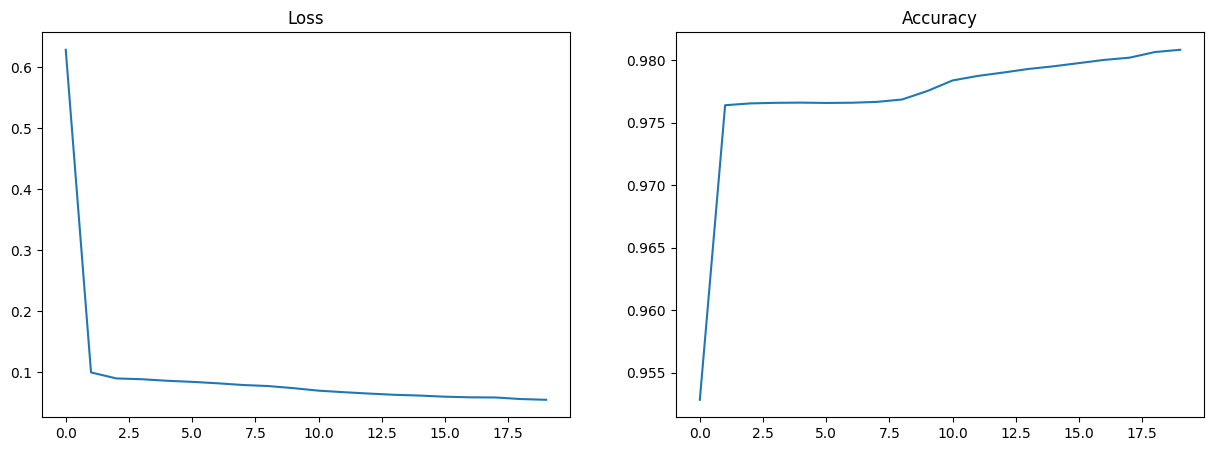

In [35]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

unet = unet_model(input_size, n_filters, n_classes, merge_mode='concat')
unet.summary()

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = unet.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


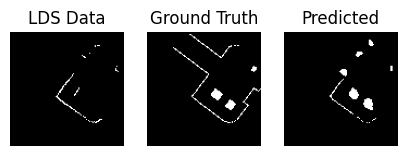

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


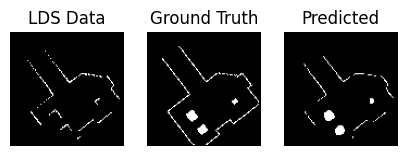

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


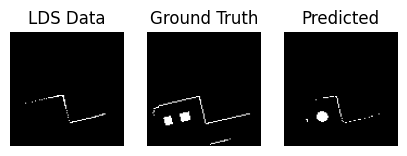

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


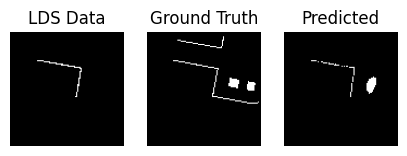

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


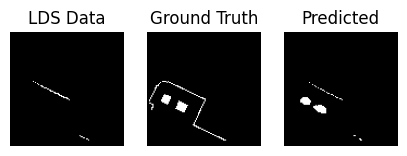

In [36]:
show_predictions(dataset, 5)

**Add mode**

Make sure all of the following are done _without padding pre-processing_.

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: add
Added final cropping layer: w=7, h=7


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 112, 112, 1)    │              0 │ input_layer_6[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 112, 112, 32)   │            320 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ conv2d_62[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 56, 56, 32)     │              0 │ conv2d_63[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 56, 56, 64)     │         18,496 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ conv2d_64[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 28, 28, 64)     │              0 │ conv2d_65[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 28, 28, 128)    │        147,584 │ conv2d_66[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 14, 14, 128)    │              0 │ conv2d_67[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 14, 14, 256)    │        295,168 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 14, 14, 256)    │        590,080 │ conv2d_68[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 14, 14, 256)    │              0 │ conv2d_69[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 7, 7, 256)      │              0 │ dropout_8[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 7, 7, 512)      │      1,180,160 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)   

 Total params: 7,855,842 (29.97 MB)

 Trainable params: 7,855,842 (29.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 272ms/step - accuracy: 0.9654 - loss: 1.5452
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9765 - loss: 0.1221
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9764 - loss: 0.0898
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9769 - loss: 0.0857
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9764 - loss: 0.0871
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9764 - loss: 0.0849
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9765 - loss: 0.0827
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9763 - loss: 0.0810
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9762 - loss: 0.0793
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9762 - loss: 0.0776
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9769 - loss: 0.0735
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/ste

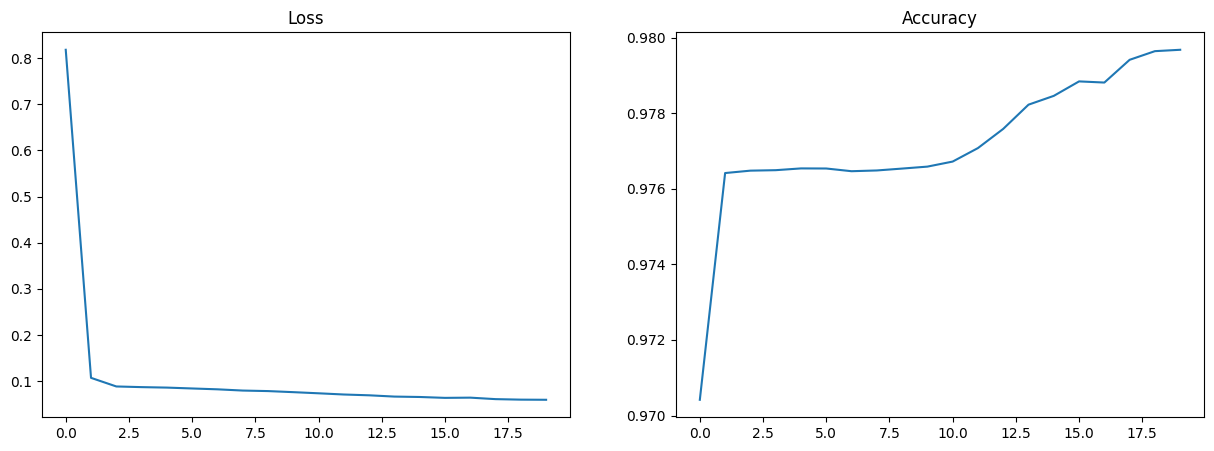

In [37]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

unet = unet_model(input_size, n_filters, n_classes, merge_mode='add')
unet.summary()

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = unet.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


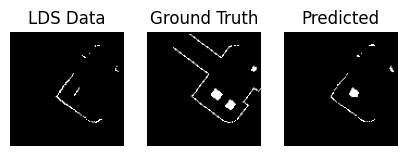

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


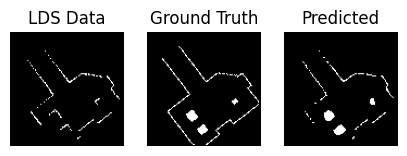

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


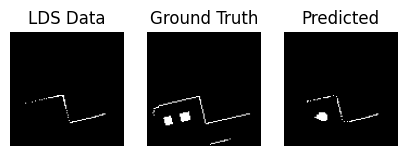

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


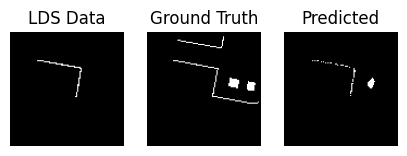

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


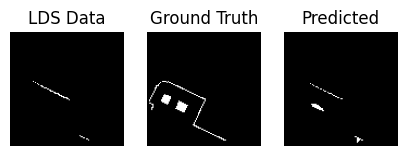

In [38]:
show_predictions(dataset, 5)

### Results

Stats:
* Add:
  * Trainable params: 7,855,842 (29.97 MB)
  * 5 epochs on GPU: 46sec, 5s/epoch, 128ms/step, accuracy: 0.9764, loss: 0.0871
  * 20 epochs on GPU: 103sec, 4s/epoch, 124ms/step, accuracy: 0.9797, loss: 0.0.0598
  * Visually: almost the same results as for Concatenation, but ever so slightly better
* Concatenation:
  * Trainable params: 8,639,202 (32.96 MB)
  * 5 epochs on GPU: 47sec, 5s/epoch, 137ms/step, accuracy: 0.9770, loss: 0.0852
  * 20 epochs on GPU: 117sec, 5s/epoch, 139ms/step, accuracy: 0.9806, loss: 0.0555

Conclusion:
* They're pretty much the same in terms of training time and results. Add is apparently ever so slightly better in terms of both efficiency and effectiveness. But the difference is really pretty negligeable in both cases.

### Other Observations
* It's interesting to see that the model is starting to infer the presence of whole objects. It's clearly beginning to over-train on this particular map.

## MobileNet: Depthwise Separable Convolutions
The next improvement should make the training times considerably less, which means that we can more easily train for hundreds of epochs. This replaces the traditional full convolution with a _depthwise separable_ convolution.

It applies the 3x3 convolution against the channels independently, and then applies a 1x1 depthwise convolution to merge them. It significantly reduces the number of parameters.

Note that there's no up-sampling equivalent of a depthwise convolution, in contrast to full convolutions which have `Conv2DTranspose`. Options are:
* Use `Conv2DTranspose`.
* Do a parameterless upsample first via `UpSampling2D` followed by a depthwise separable convolution

Do the mess in trying to experiment with options here, I'll copy-paste the code and mess around with the copy. But I'll be otherwise creating the same shaped UNet model.

In [24]:
def ds_conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Depthwise Separable Convolutional downsampling block.

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = SeparableConv2D(filters=n_filters,
                  kernel_size=(3,3),
                  activation='relu',
                  padding='same',
                  depthwise_initializer='he_normal',
                  pointwise_initializer='he_normal')(inputs)
    conv = SeparableConv2D(filters=n_filters,
                  kernel_size=(3,3),
                  activation='relu',
                  padding='same',
                  depthwise_initializer='he_normal',
                  pointwise_initializer='he_normal')(inputs)

    # dropout for some layers
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # skip connection needs to be pre-downsampled as it'll be
    # used on the way up post-upscale
    skip_connection = conv

    # max_pooling for downsampling layers
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv

    return next_layer, skip_connection

In [25]:
def ds_upsampling_block(expansive_input, contractive_input, n_filters=32, merge_mode='concat', upscale_mode='ds'):
    """
    Depthwise Separable Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
        merge_mode -- one of: 'concat' or 'add'
        upscale_mode -- one of: 'transpose' or 'ds'
    Returns:
        conv -- Tensor output
    """

    if upscale_mode == 'transpose':
      up = Conv2DTranspose(
                  filters=n_filters,    # number of filters
                  kernel_size=(3,3),    # Kernel size
                  strides=2,
                  padding='same')(expansive_input)
    elif upscale_mode == 'ds':
      up = UpSampling2D(size=(2,2), interpolation='nearest')(expansive_input)
      up = SeparableConv2D(filters=n_filters,
                    kernel_size=(3,3),
                    activation='relu',
                    padding='same',
                    depthwise_initializer='he_normal',
                    pointwise_initializer='he_normal')(up)
    else:
      raise ValueError(f"Unknown upscale mode: {upscale_mode}")

    # Merge the previous output and the contractive_input
    if merge_mode == 'concat':
      merge = Concatenate(axis=3)([up, contractive_input])
    elif merge_mode == 'add':
      merge = Add()([up, contractive_input])
    else:
      raise ValueError(f"Unknown merge mode: {merge_mode}")

    conv = SeparableConv2D(n_filters,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='same',
                 depthwise_initializer='he_normal',
                 pointwise_initializer='he_normal')(merge)
    conv = SeparableConv2D(n_filters,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='same',
                 depthwise_initializer='he_normal',
                 pointwise_initializer='he_normal')(conv)

    return conv

In [43]:
def ds_model(input_size, n_filters, n_classes, merge_mode='concat', upscale_mode='ds'):
    """
    Depthwise Separable Unet model.

    Has 4 2x2 downsampling blocks matched up with 4 2x2 upsampling blocks.
    The input dimensions must be multiples of 2**4 = 16 or off-by-one errors
    will occur.

    Arguments:
        input_size (x, y, channels) -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
        merge_mode -- one of: 'concat' or 'add'
        upscale_mode -- one of: 'transpose' or 'ds'
    Returns:
        model -- tf.keras.Model
    """
    # Prepare input
    # (Pad up to the nearest multiple of 16 if needed)
    inputs = Input(input_size)
    pad_h = 16 - input_size[0] % 16
    pad_w = 16 - input_size[1] % 16
    print(f"Input size: {input_size}")
    if pad_h > 0 or pad_w > 0:
      print(f"Added padding layer: w={pad_w}, h={pad_h}")
      padded_inputs = ZeroPadding2D(padding=((pad_h//2, pad_h-pad_h//2), (pad_w//2, pad_w-pad_w//2)))(inputs)
    else:
      padded_inputs = inputs

    print(f"Skip-connection merge mode: {merge_mode}")
    print(f"Upscale mode:               {upscale_mode}")

    # Contracting Path (encoding)
    cblock1 = ds_conv_block(padded_inputs, n_filters)
    cblock2 = ds_conv_block(cblock1[0], n_filters*2)
    cblock3 = ds_conv_block(cblock2[0], n_filters*4)
    cblock4 = ds_conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = ds_conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) # no downsampling

    # Expanding Path (decoding)
    ublock6 = ds_upsampling_block(cblock5[0], cblock4[1], n_filters*8, merge_mode, upscale_mode)
    ublock7 = ds_upsampling_block(ublock6, cblock3[1], n_filters*4, merge_mode, upscale_mode)
    ublock8 = ds_upsampling_block(ublock7, cblock2[1], n_filters*2, merge_mode, upscale_mode)
    ublock9 = ds_upsampling_block(ublock8, cblock1[1], n_filters, merge_mode, upscale_mode)

    # Use full convolution in final layers
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Collapse channels down to output classes - using logits so no activation function
    conv10 = Conv2D(filters=n_classes, kernel_size=(1,1), padding='same')(conv9)

    outputs = conv10
    if pad_h > 0 or pad_w > 0:
      print(f"Added final cropping layer: w={pad_w}, h={pad_h}")
      outputs = Cropping2D(cropping=((pad_h//2, pad_h-pad_h//2), (pad_w//2, pad_w-pad_w//2)))(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Upscale mode:               ds
Added final cropping layer: w=7, h=7


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_10         │ (None, 112, 112, 1)    │              0 │ input_layer_10[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_87       │ (None, 112, 112, 32)   │             73 │ zero_padding2d_10[0][… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 56, 56, 32)     │              0 │ separable_conv2d_87[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_89       │ (None, 56, 56, 64)     │          2,400 │ max_pooling2d_32[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 28, 28, 64)     │              0 │ separable_conv2d_89[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_91       │ (None, 28, 28, 128)    │          8,896 │ max_pooling2d_33[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34          │ (None, 14, 14, 128)    │              0 │ separable_conv2d_91[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_93       │ (None, 14, 14, 256)    │         34,176 │ max_pooling2d_34[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 14, 14, 256)    │              0 │ separable_conv2d_93[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_35          │ (None, 7, 7, 256)      │              0 │ dropout_16[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_95       │ (None, 7, 7, 512)      │        133,888 │ max_pooling2d_35[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 7, 7, 512)      │              0 │ separable_conv2d_95[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_12          │ (None, 14, 14, 512)    │              0 │ dropout_17[0][0]       │
│ (UpSampling2D)       

 Total params: 646,987 (2.47 MB)

 Trainable params: 646,987 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.9442 - loss: 0.5925
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9767 - loss: 0.1117
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9764 - loss: 0.0904
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9765 - loss: 0.0894
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9766 - loss: 0.0886
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9769 - loss: 0.0875
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9769 - loss: 0.0880
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9765 - loss: 0.0890
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9766 - loss: 0.0875
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9768 - loss: 0.0872
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9762 - loss: 0.0873
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accurac

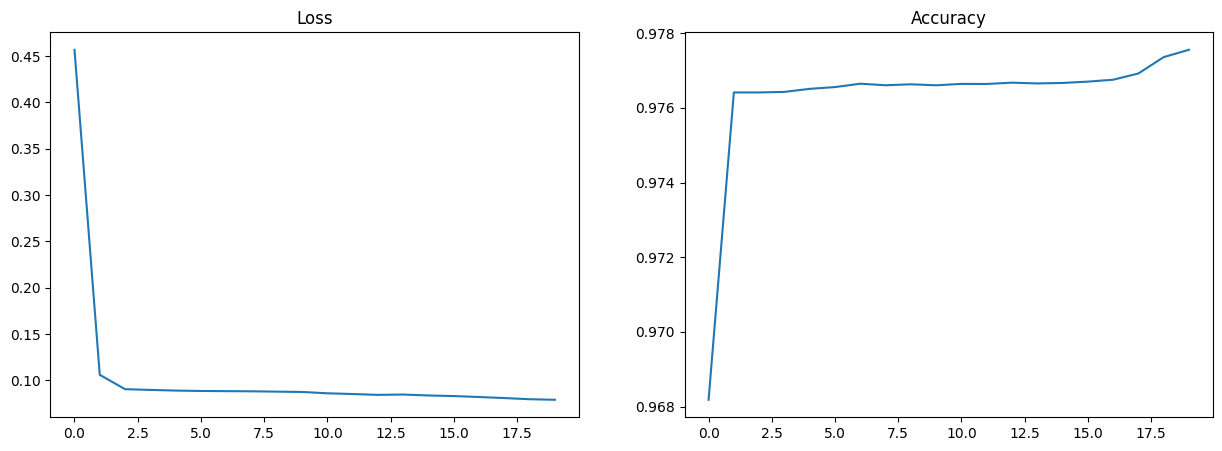

In [46]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

unet = ds_model(input_size, n_filters, n_classes, upscale_mode='ds')
unet.summary()

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = unet.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


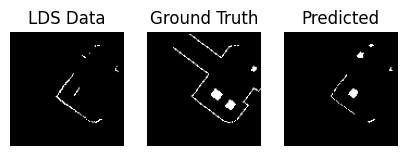

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


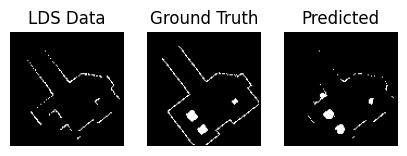

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


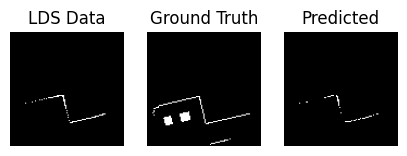

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


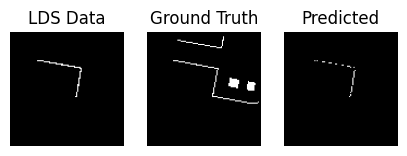

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


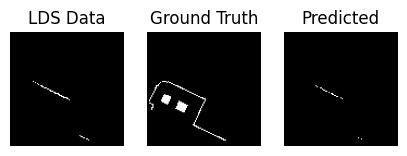

In [40]:
show_predictions(dataset, 5)

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Upscale mode:               transpose
Added final cropping layer: w=7, h=7


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 105, 105, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_9          │ (None, 112, 112, 1)    │              0 │ input_layer_9[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_69       │ (None, 112, 112, 32)   │             73 │ zero_padding2d_9[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 56, 56, 32)     │              0 │ separable_conv2d_69[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_71       │ (None, 56, 56, 64)     │          2,400 │ max_pooling2d_28[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 28, 28, 64)     │              0 │ separable_conv2d_71[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_73       │ (None, 28, 28, 128)    │          8,896 │ max_pooling2d_29[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 14, 14, 128)    │              0 │ separable_conv2d_73[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_75       │ (None, 14, 14, 256)    │         34,176 │ max_pooling2d_30[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 14, 14, 256)    │              0 │ separable_conv2d_75[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 7, 7, 256)      │              0 │ dropout_14[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_77       │ (None, 7, 7, 512)      │        133,888 │ max_pooling2d_31[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 7, 7, 512)      │              0 │ separable_conv2d_77[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_16       │ (None, 14, 14, 256)    │      1,179,904 │ dropout_15[0][0]       │
│ (Conv2DTranspose)    

 Total params: 2,030,987 (7.75 MB)

 Trainable params: 2,030,987 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.8875 - loss: 0.6186
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9765 - loss: 0.1300
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9765 - loss: 0.0904
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9763 - loss: 0.0893
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9766 - loss: 0.0890
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9764 - loss: 0.0880
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9764 - loss: 0.0872
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9766 - loss: 0.0853
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9769 - loss: 0.0840
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9765 - loss: 0.0843
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9764 - loss: 0.0833
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accurac

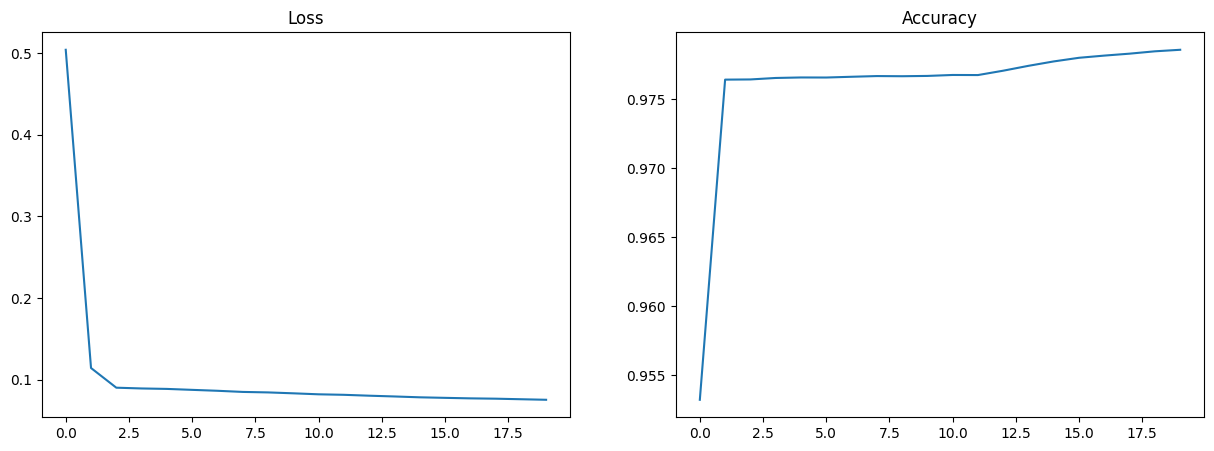

In [44]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

unet = ds_model(input_size, n_filters, n_classes, upscale_mode='transpose')
unet.summary()

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = unet.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


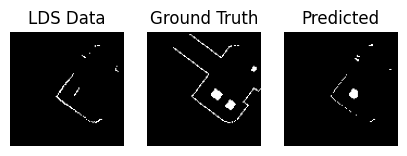

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


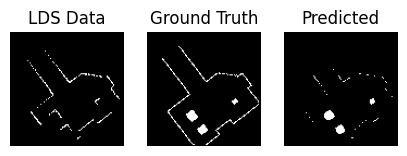

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


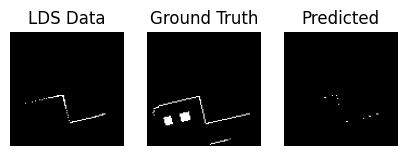

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


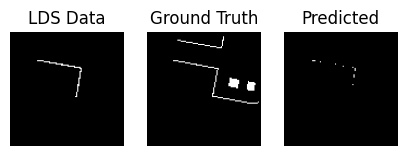

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


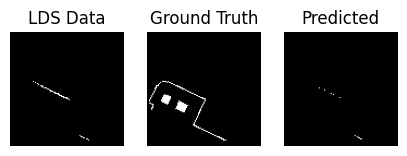

In [45]:
show_predictions(dataset, 5)

### Learnings
Stats:
* Full Convolutions - Add merge mode:
  * Trainable params: 7,855,842 (29.97 MB)
  * 5 epochs on GPU: 5s/epoch, 128ms/step, accuracy: 0.9764, loss: 0.0871
  * 20 epochs on GPU: 103sec, 4s/epoch, 124ms/step, accuracy: 0.9797, loss: 0.0.0598
  * Visually: almost the same results as for Concatenation, but ever so slightly better
* Full Convolutions - Concatenation merge mode:
  * Trainable params: 8,639,202 (32.96 MB)
  * 5 epochs on GPU: 5s/epoch, 137ms/step, accuracy: 0.9770, loss: 0.0852
  * 20 epochs on GPU: 117sec, 5s/epoch, 139ms/step, accuracy: 0.9806, loss: 0.0555
* Depthwise Convolutions - 'ds' upscale mode (concat merge mode):
  * Trainable params: 646,987 (2.47 MB) - 7.5% of equivalent full-convolutions model
  * 5 epochs on GPU: 3s/epoch, 79ms/step, accuracy: 0.9760, loss: 0.0897
  * 20 epochs on GPU: 96sec, 5s/epoch, 82ms/step, accuracy: 0.9781, loss: 0.0768
  * Visually: noticeably worse results
* Depthwise Convolutions - 'transpose' upscale mode (concat merge mode):
  * Trainable params: 2,030,987 (7.75 MB)
  * 5 epochs on GPU: 2s/epoch, 74ms/step, accuracy: 0.9766, loss: 0.0890
  * 20 epochs on GPU: 66sec, 2s/epoch, 78ms/step, accuracy: 0.9783, loss: 0.0759
  * Visually: starting to do really bad. Noticeably worse than DS upscale mode.

While we've significantly reduced the parameter count, and we've apparently reduced per-step training time by 40%, the total training time isn't much less. In the 'ds' upscale run reported above I got 96sec (18% improvement), which I repeated on a later attempt; in a separate run I got 125sec (7% worse).

I'm surprised that using a traditional Conv2DTranspose did so badly on the upscale. But I can't bo bothered looking into it.

It would appear that for my current model and this problem set, the parameter count improvement conferred through depthwise convolutions doesn't translate into helping me to quickly iterate by speeding up training time. In fact, in order to reach the same effectiveness, I'll need to train for a bit longer, which more than consumes any speed improvements I've gained.

The parameter reduction will likely benefit me a lot once I come to try to move to the actual mobile robovac. But in the meantime I might as well keep the model architecture simple while I'm experimenting.

## Later: Blurred Loss Function

In [ ]:
# From ChatGPT
import tensorflow as tf

# Define the blurring kernel, e.g., a 3x3 Gaussian kernel
def gaussian_blur(image, kernel_size=3, sigma=1.0):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=tf.float32)
    gaussian_1d = tf.exp(-tf.square(x) / (2 * sigma ** 2))
    gaussian_1d /= tf.reduce_sum(gaussian_1d)

    kernel = tf.tensordot(gaussian_1d, gaussian_1d, axes=0)
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]
    kernel = tf.tile(kernel, [1, 1, tf.shape(image)[-1], 1])  # Match input channels

    # Apply the kernel as a convolution
    image = tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME')
    return image

# Define the custom loss function with blurring
def blurred_binary_crossentropy(y_true, y_pred):
    # Apply Gaussian blur to both ground truth and predictions
    y_true_blurred = gaussian_blur(tf.cast(y_true, tf.float32))
    y_pred_blurred = gaussian_blur(tf.cast(y_pred, tf.float32))

    # Use binary cross-entropy on blurred images
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true_blurred, y_pred_blurred))

# Compile your model with the custom loss function
model.compile(optimizer='adam', loss=blurred_binary_crossentropy)